# EasyOCR for Tunisian License Plate Detection

This notebook demonstrates how to use EasyOCR to detect and recognize Tunisian license plates with focus on extracting numbers and inserting the Arabic text "تونس" between them.

In [125]:
!pip install easyocr


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [126]:
import matplotlib.pyplot as plt
import cv2
import easyocr
from IPython.display import Image
import numpy as np
import re

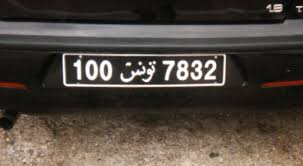

In [127]:
# Display the sample image
Image("/Users/macbook/Documents/Personnel/Car-Number-Plates-Detection/plates/tunis.jpeg")

## Enhanced Image Preprocessing

Apply multiple preprocessing techniques to improve Arabic text detection.

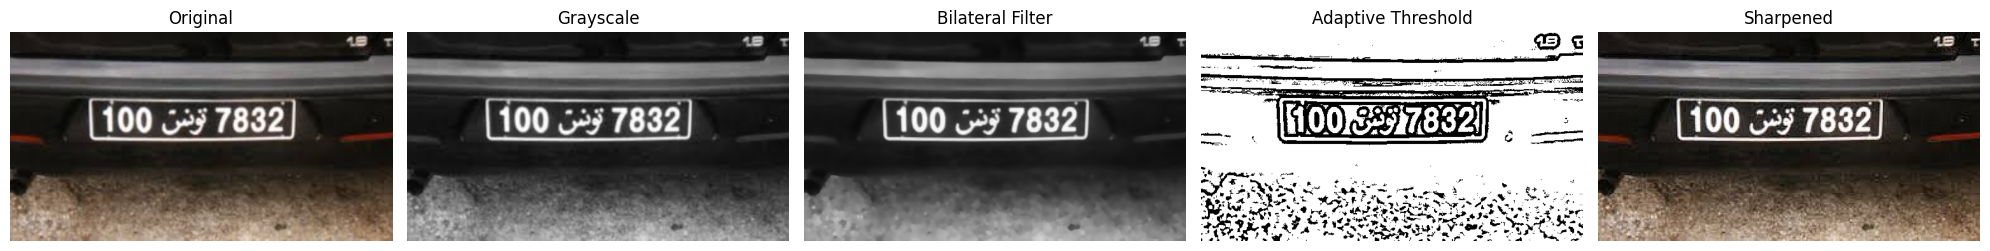

In [128]:
def preprocess_image(image_path):
    """Apply multiple preprocessing techniques to improve Arabic detection"""
    # Read image
    original = cv2.imread(image_path)
    if original is None:
        return None, None
    
    # Make sure image is large enough
    if original.shape[1] < 600:
        scale = 600 / original.shape[1]
        original = cv2.resize(original, (0, 0), fx=scale, fy=scale)
    
    # Create a list of preprocessed variants
    preprocessed_images = []
    
    # 1. Original image
    preprocessed_images.append(original)
    
    # 2. Grayscale
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    preprocessed_images.append(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR))
    
    # 3. Bilateral filter (reduces noise while keeping edges sharp)
    bilateral = cv2.bilateralFilter(gray, 11, 17, 17)
    preprocessed_images.append(cv2.cvtColor(bilateral, cv2.COLOR_GRAY2BGR))
    
    # 4. Adaptive threshold (helps with contrast)
    thresh = cv2.adaptiveThreshold(bilateral, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 11, 2)
    preprocessed_images.append(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))
    
    # 5. Edge enhancement
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(original, -1, kernel)
    preprocessed_images.append(sharpened)
    
    # Display the preprocessing results
    plt.figure(figsize=(20, 10))
    titles = ['Original', 'Grayscale', 'Bilateral Filter', 'Adaptive Threshold', 'Sharpened']
    
    for i, img in enumerate(preprocessed_images):
        plt.subplot(1, 5, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return preprocessed_images, original

# Preprocess the image
preprocessed_images, original_img = preprocess_image('/Users/macbook/Documents/Personnel/Car-Number-Plates-Detection/plates/tunis.jpeg')

## Optimized OCR with Arabic Language Support

Initialize EasyOCR with Arabic and English languages and special configuration for Arabic detection.

In [129]:
# Initialize the reader with Arabic as the primary language, followed by English
# Setting decoder parameters to optimize for Arabic text detection
reader = easyocr.Reader(['ar', 'en'], gpu=False, recog_network='arabic_g1')

print("OCR loaded with Arabic support. Processing images...")

Using CPU. Note: This module is much faster with a GPU.


OCR loaded with Arabic support. Processing images...


In [130]:
# Apply OCR to each preprocessed image and collect all results
all_results = []

for i, img in enumerate(preprocessed_images):
    print(f"Processing image variant {i+1}...")
    # Use detail=1 to get bounding box info
    # Allow lower confidence to catch more potential matches
    results = reader.readtext(img, paragraph=False, detail=1, 
                               min_size=10, contrast_ths=0.1,
                               adjust_contrast=0.5)
    all_results.append(results)
    
    # Uncomment to see detailed results
    # print(f"Found {len(results)} text regions in variant {i+1}:")
    # for bbox, text, prob in results:
    #     print(f"  Text: '{text}' with confidence {prob:.2f}")

# Get the original OCR results
output = all_results[0]

Processing image variant 1...
Processing image variant 2...
Processing image variant 2...
Processing image variant 3...
Processing image variant 3...
Processing image variant 4...
Processing image variant 4...
Processing image variant 5...
Processing image variant 5...


## Check for Arabic Letters and Insert تونس

Detect if any result contains Arabic letters and find the numbers to format the license plate.

In [131]:
def extract_numbers_and_insert_tunisia(txt):
    """Extract numbers from OCR results and insert تونس between them"""
    # Collect all detected text
    all_text = txt
    print(f"All detected text: {all_text}")
    
    # Extract numbers using regex
    numbers = re.findall(r'\d+', all_text)
    print(f"Extracted numbers: {numbers}")
    
    # Sort numbers by their occurrence in the text
    # This helps maintain the original order
    sorted_numbers = sorted(numbers, key=lambda x: all_text.find(x))
    
    # Remove duplicates while preserving order
    unique_numbers = []
    for num in sorted_numbers:
        if num not in unique_numbers:
            unique_numbers.append(num)
    
    print(f"Unique numbers in order: {unique_numbers}")
    
    # Build the license plate text with تونس in the middle
    if len(unique_numbers) >= 2:
        # Typical format: first_number تونس second_number
        first_part = unique_numbers[0]
        second_part = unique_numbers[1]
        complete_plate = f"{first_part} تونس {second_part}"
        
        # If there are more numbers, add them too
        if len(unique_numbers) > 2:
            complete_plate += " " + " ".join(unique_numbers[2:])
    elif len(unique_numbers) == 1:
        # Only one number detected
        complete_plate = f"تونس {unique_numbers[0]}"
    else:
        # No numbers detected
        complete_plate = "تونس"
    
    return complete_plate, unique_numbers

## Process Each Detection and Look for Arabic Letters

Check each result for Arabic letters ت, و, or ن to find the Tunisian license plate identification.

In [132]:
# Process the first variant results (output)
formatted_plate = ""
extracted_numbers = []
found_arabic = False

# First check if any result contains Arabic letters
for results_list in all_results:
    for bbox, text, prob in results_list:
        # Check for Arabic letters (specifically ت, و, or ن which are in تونس)
        if 'ت' in text or 'و' in text or 'ن' in text or 'س' in text:
            print(f"✓ Found Arabic letters in '{text}' with confidence {prob:.2f}")
            formatted_plate, extracted_numbers = extract_numbers_and_insert_tunisia(text)
            print(f"\nFormatted plate: {formatted_plate}")
            found_arabic = True
            break
            
    if found_arabic:
        break

# If no Arabic was found, use the first detection
if not found_arabic and len(all_results) > 0 and len(all_results[0]) > 0:
    bbox, text, prob = all_results[0][0]
    print(f"No Arabic letters found, using first detection: '{text}' with confidence {prob:.2f}")
    formatted_plate, extracted_numbers = extract_numbers_and_insert_tunisia(text)
    print(f"\nFormatted plate: {formatted_plate}")

✓ Found Arabic letters in '7832 تونىن 100' with confidence 0.49
All detected text: 7832 تونىن 100
Extracted numbers: ['7832', '100']
Unique numbers in order: ['7832', '100']

Formatted plate: 7832 تونس 100


## Visualize the License Plate with Inserted تونس

Show the results with the Arabic text properly positioned between numbers.

In [133]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

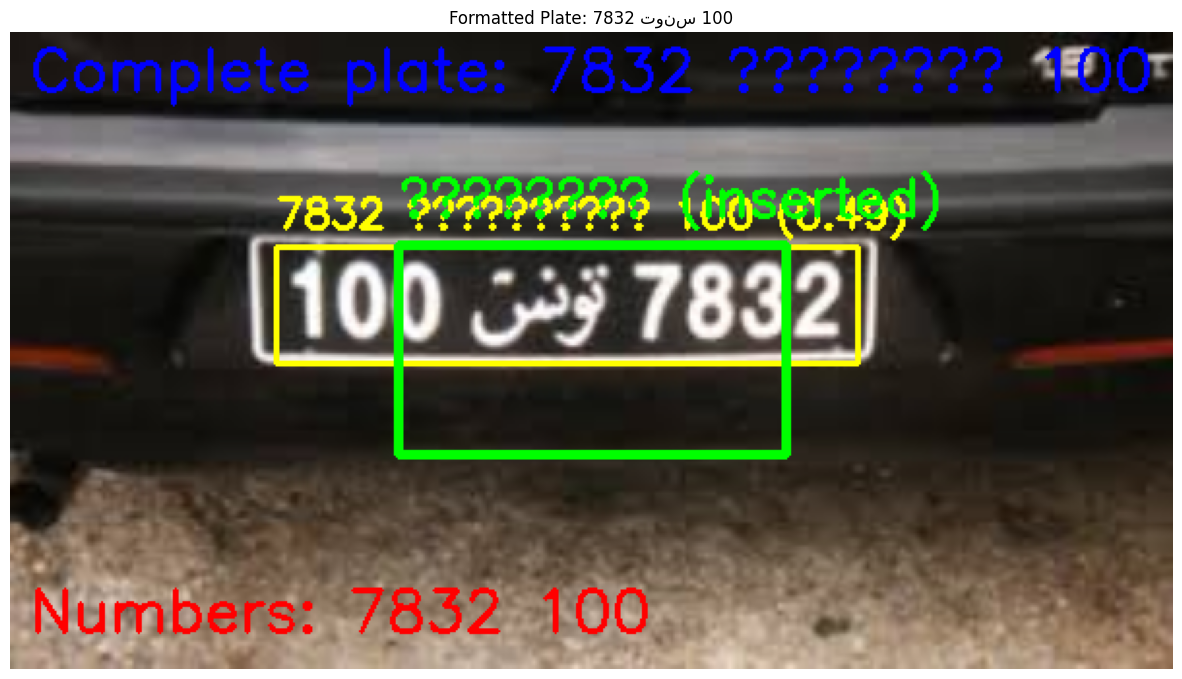

In [134]:
# Function to visualize license plate with inserted تونس
def visualize_plate_with_tunisia(img, all_results_list, formatted_plate, numbers):
    """Visualize license plate with تونس inserted between numbers"""
    # Create a copy for visualization
    visualization = img.copy()
    
    # Draw all detected text boxes (from the first variant to keep it clean)
    if len(all_results_list) > 0 and len(all_results_list[0]) > 0:
        # Draw detection boxes
        for bbox, text, prob in all_results_list[0]:
            points = np.array(bbox, dtype=np.int32)
            # Draw yellow boxes for all detections
            cv2.polylines(visualization, [points], True, (0, 255, 255), 2)
            
            # Add text label
            x_min, y_min = points.min(axis=0)
            cv2.putText(visualization, f"{text} ({prob:.2f})", 
                       (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        # Estimate the center position for the inserted تونس
        h, w = visualization.shape[:2]
        center_x = w//2  # Fix: Calculate center_x only
        center_y = h//2  # Fix: Calculate center_y separately
        
        # Draw a green box for the manually inserted تونس
        box_w, box_h = w//3, h//3
        tunis_box = np.array([
            [center_x - box_w//2, center_y - box_h//2],
            [center_x + box_w//2, center_y - box_h//2],
            [center_x + box_w//2, center_y + box_h//2],
            [center_x - box_w//2, center_y + box_h//2]
        ], dtype=np.int32)
        
        # Draw a green box for تونس
        cv2.polylines(visualization, [tunis_box], True, (0, 255, 0), 3)
        cv2.putText(visualization, "تونس (inserted)", 
                   (center_x - box_w//2, center_y - box_h//2 - 15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Add the complete formatted plate text at the top
    cv2.putText(visualization, f"Complete plate: {formatted_plate}", 
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Add numbers at the bottom
    if numbers:
        cv2.putText(visualization, f"Numbers: {' '.join(numbers)}", 
                   (10, visualization.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return visualization

# Create the visualization if we have a formatted plate
if formatted_plate:
    result_img = visualize_plate_with_tunisia(original_img, all_results, formatted_plate, extracted_numbers)
    
    # Display the result
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Formatted Plate: {formatted_plate}")
    plt.show()

## Complete Function to Process Tunisian License Plates

Combine all steps into a comprehensive function to process any Tunisian license plate.

Processing license plate: /Users/macbook/Documents/Personnel/Car-Number-Plates-Detection/plates/tunis.jpeg


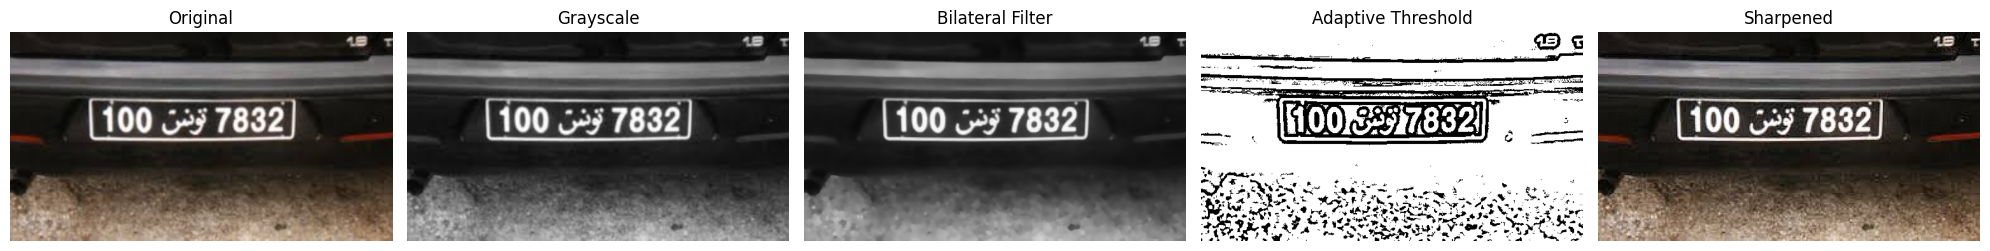

Variant 1: Found 1 text regions
Variant 2: Found 1 text regions
Variant 2: Found 1 text regions
Variant 3: Found 1 text regions
Variant 3: Found 1 text regions
Variant 4: Found 1 text regions
Variant 4: Found 1 text regions
Variant 5: Found 1 text regions
✓ Found Arabic letters in '7832 تونىن 100' with confidence 0.49
All detected text: 7832 تونىن 100
Extracted numbers: ['7832', '100']
Unique numbers in order: ['7832', '100']
Variant 5: Found 1 text regions
✓ Found Arabic letters in '7832 تونىن 100' with confidence 0.49
All detected text: 7832 تونىن 100
Extracted numbers: ['7832', '100']
Unique numbers in order: ['7832', '100']


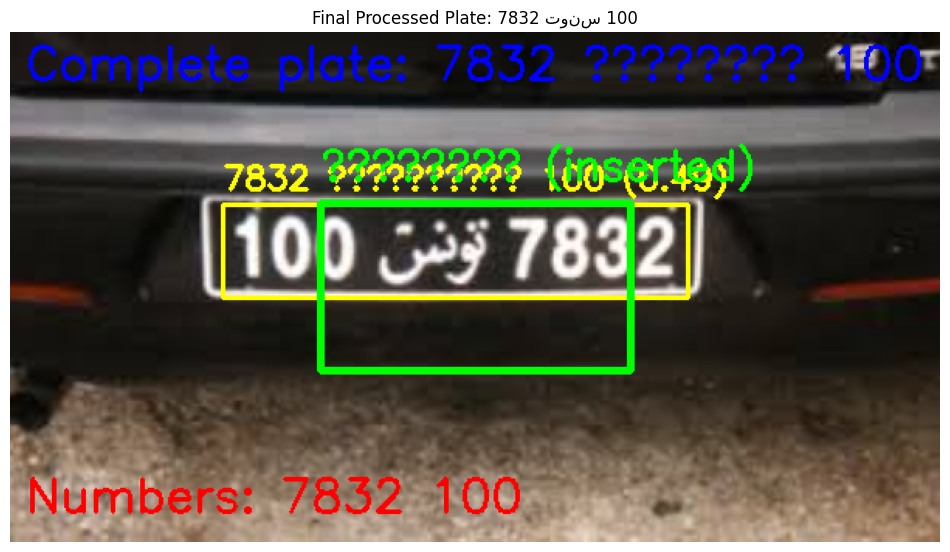

✓ Successfully processed license plate
  - Extracted numbers: 7832 100
  - Final plate text: 7832 تونس 100


In [136]:
def process_tunisian_plate(image_path):
    """Complete pipeline to process a Tunisian license plate with inserted تونس"""
    print(f"Processing license plate: {image_path}")
    
    # 1. Preprocess image with multiple techniques
    preprocessed_images, original = preprocess_image(image_path)
    if original is None:
        return None, "Error: Could not read image", None
    
    # 2. Apply OCR to all preprocessed variants
    all_results = []
    for i, img in enumerate(preprocessed_images):
        results = reader.readtext(img, paragraph=False, detail=1, 
                                min_size=10, contrast_ths=0.1,
                                adjust_contrast=0.5)
        all_results.append(results)
        print(f"Variant {i+1}: Found {len(results)} text regions")
    
    # 3. Look for Arabic letters in any result
    formatted_plate = ""
    extracted_numbers = []
    found_arabic = False
    
    for results_list in all_results:
        for bbox, text, prob in results_list:
            # Check for Arabic letters (specifically ت, و, or ن which are in تونس)
            if 'ت' in text or 'و' in text or 'ن' in text or 'س' in text:
                print(f"✓ Found Arabic letters in '{text}' with confidence {prob:.2f}")
                formatted_plate, extracted_numbers = extract_numbers_and_insert_tunisia(text)
                found_arabic = True
                break
        if found_arabic:
            break
    
    # 4. If no Arabic was found, use the first detection
    if not found_arabic and len(all_results) > 0 and len(all_results[0]) > 0:
        bbox, text, prob = all_results[0][0]
        print(f"No Arabic letters found, using first detection: '{text}' with confidence {prob:.2f}")
        formatted_plate, extracted_numbers = extract_numbers_and_insert_tunisia(text)
    
    # 5. Create visualization
    result_img = visualize_plate_with_tunisia(original, all_results, formatted_plate, extracted_numbers)
    
    return result_img, formatted_plate, extracted_numbers

# Process another sample image
result_img, formatted_plate, extracted_numbers = process_tunisian_plate(
    '/Users/macbook/Documents/Personnel/Car-Number-Plates-Detection/plates/tunis.jpeg')

# Display results
if result_img is not None:
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Final Processed Plate: {formatted_plate}")
    plt.axis('off')
    plt.show()
    
    print(f"✓ Successfully processed license plate")
    print(f"  - Extracted numbers: {' '.join(extracted_numbers)}")
    print(f"  - Final plate text: {formatted_plate}")
else:
    print("⚠ Could not process license plate image")

## Process Multiple Plates

Function to process multiple license plate images at once.

In [137]:
def process_multiple_plates(image_paths):
    """Process multiple license plate images"""
    results = []
    
    for i, path in enumerate(image_paths):
        print(f"\nProcessing plate {i+1}/{len(image_paths)}: {path}")
        result_img, formatted_plate, extracted_numbers = process_tunisian_plate(path)
        
        if result_img is not None:
            results.append((path, formatted_plate, extracted_numbers))
            
            # Display in a smaller size to save space
            plt.figure(figsize=(8, 5))
            plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Plate {i+1}: {formatted_plate}")
            plt.axis('off')
            plt.show()
    
    # Print a summary
    print("\n=== Processing Summary ===")
    print(f"Successfully processed {len(results)} plates")
    for path, plate_text, numbers in results:
        print(f"- {path.split('/')[-1]}: {plate_text}")
    
    return results

# Define plate paths
plate_paths = [
    '/Users/macbook/Documents/Personnel/Car-Number-Plates-Detection/plates/tunisNT.jpeg',
    '/Users/macbook/Documents/Personnel/Car-Number-Plates-Detection/plates/tunis.jpeg'
]

# Uncomment to process multiple plates
# process_results = process_multiple_plates(plate_paths)